In [2]:
from docplex.mp.model import Model  #导出库，只用这一个就够了
import matplotlib.pyplot as plt#选取了用户47的365天的数据
import numpy as np
import pandas as pd
import csv
import cplex
from cplex.exceptions import CplexError
import time
import math

In [3]:
 #read file, for example
file_path = 'C:/Users/chenxihui/Desktop/code/project/2010.csv'
file = open(file_path)
data = []
for i in file.readlines():
    data.append(i)
file.close()

new_data = []
for row in data:
    tmp = row.strip('\n')  #去掉每行最后的回车符
    tmp = tmp.split(',')   #根据','来分割字符串，使之成为含有一个个数据的列表
    new_data.append(tmp)   #new_data的每一行数据就是一个列表
select_data = []

length=len(new_data)
for i in range(length):
    if(new_data[i][0]=='75'):#PVsize为8kwp
        select_data.append(new_data[i][3:])#[3:]

GC=[]
CL=[]
GG=[]
Battery=[]
Length_select_data = len(select_data)
for i in range(Length_select_data):
    if(select_data[i][0]=='GC'):
        GC.append(select_data[i][2:])
    elif(select_data[i][0]=='CL'):
        CL.append(select_data[i][2:])
    else:
        GG.append(select_data[i][2:])
        
Total_Load=[]
temp=[]
a=0.0
for i in range(Length_select_data):
    if(select_data[i][0]=='GC' and select_data[i+1][0]=='CL'):
        for j in range(len(select_data[i][2:])):
            a=pd.to_numeric(select_data[i][j+2])+pd.to_numeric(select_data[i+1][j+2])
            temp.append(a)
        Total_Load.append(temp)
    elif(select_data[i][0]=='GC' and select_data[i+1][0]!='CL'):
        Total_Load.append(select_data[i][2:])
    temp=[]
    
GC_temp=np.array(GC)
GC_array=[]
GC_array = GC_temp.astype(np.float)

GG_temp=np.array(GG)
GG_array=[]
GG_array = GG_temp.astype(np.float)*2

Total_Load_temp=np.array(Total_Load)
Total_Load_array=[]
Total_Load_array = Total_Load_temp.astype(np.float32)*2#功率
Total_Load_array[1]


array([4.5  , 2.004, 2.256, 2.1  , 1.008, 1.012, 1.34 , 1.034, 1.042,
       1.208, 0.996, 1.198, 2.502, 5.33 , 1.22 , 1.26 , 4.124, 1.226,
       0.85 , 4.586, 6.018, 2.282, 6.64 , 0.544, 0.388, 4.808, 3.15 ,
       4.25 , 0.434, 0.428, 0.4  , 0.36 , 0.344, 2.26 , 3.406, 3.776,
       0.476, 0.354, 3.922, 0.438, 1.494, 0.4  , 0.588, 0.488, 1.012,
       1.044, 0.252, 0.246], dtype=float32)

In [4]:
GG=[]#把96个时刻作为滚动周期
load=[]
for i in range(len(GG_array)):
    if(i==len(GG_array)-1):
        GG.append(GG_array[i])
        load.append(Total_Load_array[i])
    if((i%2==0) and (i!=len(GG_array)-1)):
        GG.append(GG_array[i])
        load.append(Total_Load_array[i])
        #print(GG[-1])
        #print(GG_array[i+1])
        GG[-1]=np.hstack((GG[-1],GG_array[i+1]))
        load[-1]=np.hstack((load[-1],Total_Load_array[i+1]))

In [83]:
GG[92]

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.038, 0.15 , 0.226, 0.288, 0.462, 0.762,
       1.05 , 1.326, 1.55 , 2.85 , 5.162, 5.988, 6.526, 7.338, 7.5  ,
       7.288, 7.4  , 7.226, 6.762, 6.676, 6.562, 5.962, 5.138, 4.138,
       2.162, 0.4  , 0.15 , 0.012, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.012, 0.126, 0.338,
       0.762, 1.426, 2.   , 2.476, 2.976, 2.75 , 3.1  , 5.176, 6.026,
       5.626, 6.812, 7.288, 7.276, 7.488, 7.188, 6.812, 4.75 , 3.088,
       3.426, 1.762, 0.5  , 0.2  , 0.026, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [5]:
T_tou=[0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,
       0.38588,0.38588, 0.38588,0.38588, 
      0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,
      0.38588,0.38588,0.38588,0.38588,0.38588,0.38588,
      0.37147,0.37147,0.37147,0.37147,
      0.2134,0.2134,0.2134,0.2134]
T_tou=np.hstack((T_tou,T_tou))

In [10]:
def milp_one2(T_tou,T_fit,Total_Load_array,GG_array,bat_state,i,d,pb_bar,bat_max,efficiency_i,efficiency_c,dh,pg_bar):
    expression=0
    tfit=[]
    model = Model()####对变量命名并且给出上下界
    var_list = np.arange(0,96,1)
    X1 = model.continuous_var_list(var_list,lb=0.0,ub=pg_bar,name='X1')#代表pg_import(pg+)，功率
    X2 = model.continuous_var_list(var_list,lb=0.0,ub=pg_bar,name='X2')#代表pg_export(pg-)
    Y1 = model.continuous_var_list(var_list,lb=0.0,ub=pb_bar,name='Y1')#代表充电功率（pb+）
    Y2 = model.continuous_var_list(var_list,lb=0.0,ub=pb_bar,name='Y2')#代表放电功率（pb-）
    dg=model.binary_var_list(var_list,name='dg')#决策变量电网电力流向（0：用户到电网）
    sb=model.binary_var_list(var_list,name='sb')#决策变量电池充电状态（0：放电）
    eb=model.continuous_var_list(var_list,lb=0,name='eb')#电池容量SOC
    tou=[]
    tou.extend(T_tou[i:])
    tou.extend(T_tou[0:i])#输入分时电价
    
    for j in range(96):
        #tfit.append(T_fit)
        expression+=dh*tou[j]*X1[j]#X1为pg+,X2为pg-,Y1为pb+,Y2为pb-
        expression-=dh*T_fit*X2[j]#此处以电量为计量
    #约束条件（2） 功率平衡
        if(j+i<96):
            model.add_constraint(X1[j]-X2[j]-efficiency_i*efficiency_c*Y1[j]+(efficiency_i/efficiency_c)*Y2[j]==
                         Total_Load_array[d][j+i]-efficiency_i*GG_array[d][j+i])
        else:
            model.add_constraint(X1[j]-X2[j]-efficiency_i*efficiency_c*Y1[j]+(efficiency_i/efficiency_c)*Y2[j]==
                         Total_Load_array[d+1][j+i-96]-efficiency_i*GG_array[d+1][j+i-96])
        
    #约束条件（3） 电量约束
        bat_state.append(bat_state[-1]+dh*efficiency_c*Y1[j]-(dh/efficiency_c)*Y2[j])#约束条件（3）
        eb[j]=bat_state[-1]
        model.add_constraint(eb[j]<=bat_max)#约束条件（12）
        model.add_constraint(eb[j]>=0)#约束条件（12）
    #约束条件（4） 买电约束
        model.add_constraint(X1[j]-float(pg_bar)*dg[j]<=0)
    #约束条件（5） 卖电约束
        model.add_constraint(X2[j]+float(pg_bar)*dg[j]<=float(pg_bar))
    #约束条件（6） 充电约束
        model.add_constraint(Y1[j]-pb_bar*sb[j]<=0)
    #约束条件（7） 放电约束
        model.add_constraint(Y2[j]+pb_bar*sb[j]<=pb_bar)
    model.minimize(expression)#目标函数    
    sol = model.solve() #输出解
    #print(sol)
    temp = sol.get_all_values()
    return temp,bat_state[0]

In [6]:
def MILP_oneweek(Total_Load_array,GG_array,T_tou):
    pb_bar=5
    bat_max=14
    efficiency_i=0.9
    efficiency_c=0.95
    dh=0.5
    pg_bar=20
    T_flat=0.235018
    T_fit=0.09
    init_state=14
    bat_state=[0.5*init_state]#要输出的电池状态，这是0时刻的初始状态
    pg_import=[]
    pg_export=[]
    pb_c=[]
    pb_d=[]
    soc=[0.5*bat_max]
    a=time.time()
    for d in np.arange(92,95,1):        
        for i in range(96):
        #print(bat_state)
            temp=[]
            temp,before=milp_one2(T_tou,T_fit,Total_Load_array,GG_array,bat_state,i,d,pb_bar,bat_max,efficiency_i,efficiency_c,dh,pg_bar)
        #print(temp[96])
            soc.append(before+dh*efficiency_c*temp[96*2]-(dh/efficiency_c)*temp[96*3])#bat_state保存的是滚动域内48个时刻都要满足电池约束，所以一个遍历完后得
        #重置，而SOC是要输出的值
            bat_state=[]
            bat_state.append(soc[-1])
        #d=bat_state[-1]+0.455*a[0]-(0.5/0.91)*a[0]
            #print(temp[0])
            pg_import.append(temp[0])
            pg_export.append(temp[96])
            pb_c.append(temp[96*2])
            pb_d.append(temp[96*3])
    return soc,pg_import,pg_export,pb_c,pb_d

In [11]:
soc,pg_import,pg_export,pb_c,pb_d=MILP_oneweek(load,GG,T_tou)

In [121]:
load1=[]
GGG=[]
T_tou1=[]
for i in np.arange(92,95,1):
    load1.extend(load[i])
    GGG.extend(GG[i])
    T_tou1.extend(T_tou)


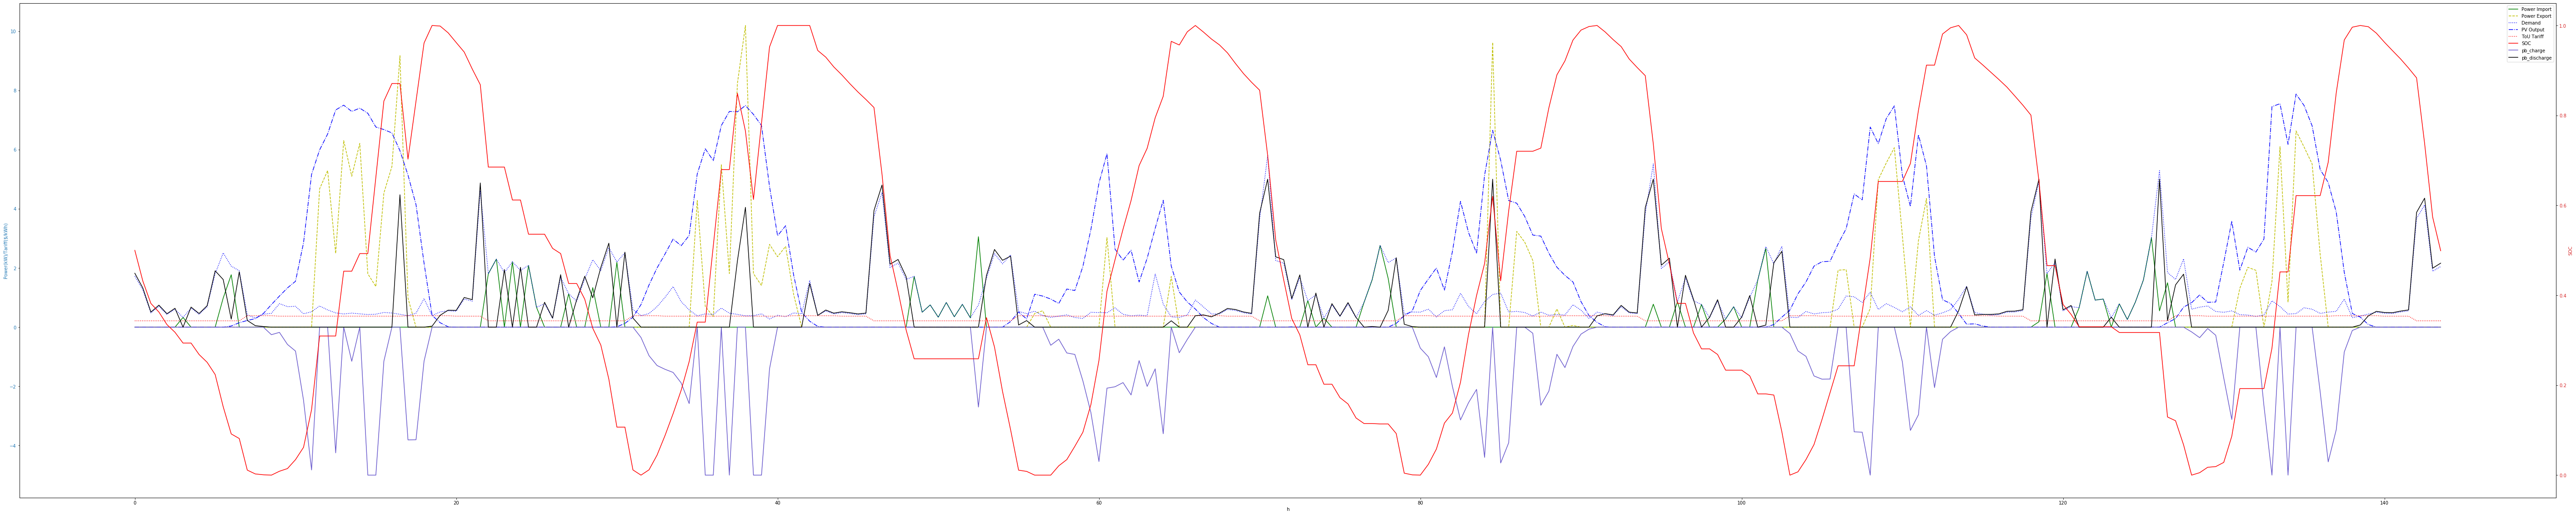

In [155]:
x = [0.5*i for i in range(48*6)]
y = [0.5*i for i in range(49)]

fig, ax1 = plt.subplots(figsize=(100,20))
color = 'tab:blue'
ax1.set_xlabel('h')
ax1.set_ylabel('Power(kW)/Tariff($/kWh)', color=color)
l1,=ax1.plot(x, np.array(pg_import), color='g',label='Power Import')
l2,=ax1.plot(x, np.array(pg_export), '--',color='y',label='Power Export')
l3,=ax1.plot(x, np.array(load1),':',color='b',label='Demand')
l4,=ax1.plot(x, np.array(GGG),'-.',color='b',label='PV Output')
l5,=ax1.plot(x, T_tou1,':',color='r',label='ToU Tariff')
l7,=ax1.plot(x, -np.array(pb_c),color='slateblue',label='pb_charge')
l8,=ax1.plot(x, pb_d,color='k',label='pb_discharge')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('SOC', color=color)  # we already handled the x-label with ax1
l6,=ax2.plot(x, np.array(soc[:288])/14, 'r',label='SOC')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend(handles=[l1,l2,l3,l4,l5,l6,l7,l8],loc=1)
#fig.tight_layout()
plt.show()

In [12]:
cost=0
for i in range(48):
    cost+=pg_import[i]*T_tou[i]-pg_export[i]*T_tou[i]
cost

-17.828570275530925